<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Rio_Dengue_Risk_Classification_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

from sklearn.model_selection import StratifiedKFold, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    balanced_accuracy_score, make_scorer,
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score,
    precision_recall_curve, confusion_matrix, classification_report,
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from xgboost import XGBClassifier

from itertools import product
from tqdm.auto import tqdm
from statsmodels.tsa.stattools import ccf

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import os, re, glob, shutil
import numpy as np
import joblib
from google.colab import drive

In [3]:
def get_data(ibge, ey_start, ey_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = ibge
  disease = "dengue"
  format = "csv"
  ew_start = 1
  ew_end = 53
  ey_start = ey_start
  ey_end = ey_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])
  dados = pd.read_csv(url_resp, index_col='SE')
  return dados

In [4]:
 # rio_neighbours_all = [3304557, 3302007, 3305554, 3303500,3301702, 3305109, 3300456, 3303203, 3302858, 3304144, 3302270, 3302858]
rio_neighbours = [3304557, 3302007, 3305554, 3303500, 3301702, 3305109, 3303203, 3302858]

In [5]:
# geojson_url = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

# muni = gpd.read_file(geojson_url)
# muni["id"] = muni["id"].astype(str)

# rio = muni[muni["id"].str.startswith("330")].copy() # Municipality rio ibge starts with 330
# ribge = [str(x).zfill(7) for x in rio_neighbours]

# rpl = pd.DataFrame({"ibge": rio["id"]})
# rpl["selected"] = "other"
# rpl.loc[rpl["ibge"].isin(ribge), "selected"] = "neighbour"
# rpl.loc[rpl["ibge"] == "3304557", "selected"] = "rio_city"

# fig = px.choropleth(
#     rpl,
#     geojson=rio.__geo_interface__,
#     locations="ibge",
#     featureidkey="properties.id",
#     color="selected",
#     color_discrete_map={
#         "other":   "lightgrey",
#         "neighbour": "orange",
#         "rio_city": "maroon",
#     }
# )

# fig.update_traces(marker_line_width=0.4, marker_line_color="black")
# fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), coloraxis_showscale=False)

# fig.show()


In [6]:
rj = []
for i, ibge in enumerate(rio_neighbours):
    data = get_data(ibge=ibge, ey_start=2010, ey_end=2025)
    data['region'] = f"r{i+1}"
    rj.append(data)

all = pd.concat(rj, ignore_index=True)

In [7]:
all.columns

Index(['data_iniSE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos',
       'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo',
       'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao',
       'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov',
       'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf',
       'notif_accum_year', 'region'],
      dtype='object')

In [8]:
all.head(5)

,data_iniSE,casos_est,casos_est_min,casos_est_max,casos,p_rt1,p_inc100k,Localidade_id,nivel,id,...,umidmin,tempmed,tempmax,casprov,casprov_est,casprov_est_min,casprov_est_max,casconf,notif_accum_year,region
0,2025-09-28,309.0,199,544.0,118,0.549897,4.663553,0,1,330455720254020368,...,41.754125,22.025125,28.983125,67.0,NaN,NaN,NaN,NaN,665981,r1
1,2025-09-21,301.0,269,353.0,239,0.605514,4.542814,0,1,330455720253920368,...,48.662471,21.936329,26.060614,89.0,NaN,NaN,NaN,NaN,665981,r1
2,2025-09-14,324.0,309,345.0,293,0.959198,4.889939,0,1,330455720253820368,...,49.199000,22.083943,27.310429,98.0,NaN,NaN,NaN,NaN,665981,r1
3,2025-09-07,293.0,282,307.0,274,0.705604,4.422075,0,1,330455720253720368,...,56.739414,21.020400,24.826800,101.0,NaN,NaN,NaN,NaN,665981,r1
4,2025-08-31,278.0,270,289.0,264,0.322483,4.195689,0,1,330455720253620368,...,48.862986,21.417529,26.341886,74.0,NaN,NaN,NaN,NaN,665981,r1


## Data Exploration

Because I want to learn how to predict the nivel, and the source uses
1. Weather
2. Twitter
3. Reported Cases

In [9]:
all.columns

Index(['data_iniSE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos',
       'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo',
       'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao',
       'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov',
       'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf',
       'notif_accum_year', 'region'],
      dtype='object')

In [10]:
cols = ['data_iniSE', 'nivel','p_inc100k', 'tweet', 'Rt', 'p_rt1', 'tempmin', 'umidmax', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'region']
all_filt = all[cols].copy()

In [11]:
all_filt.isna().sum()

,0
data_iniSE,0
nivel,0
p_inc100k,0
tweet,952
Rt,0
p_rt1,0
tempmin,0
umidmax,150
umidmed,150
umidmin,150


In [12]:
def plot_ts(df, cols, date_col="data_iniSE", region_col="region", na_fill=0):

    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    df[cols] = df[cols].fillna(na_fill)

    regions = df[region_col].unique()

    for col in cols:
        plt.figure(figsize=(17, 5))
        for r in regions:
            g = df[df[region_col] == r].sort_values(date_col)
            plt.plot(g[date_col], g[col], marker='o', markersize=2, label=f"Region {r}")
        plt.title(col)
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


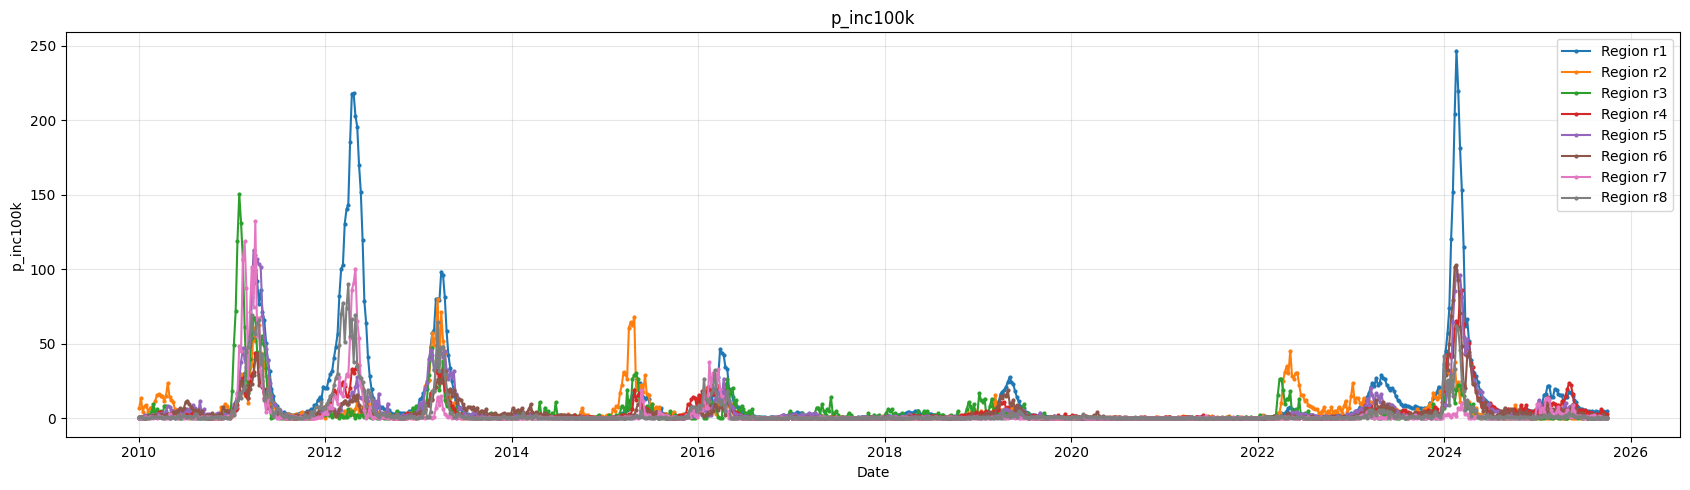

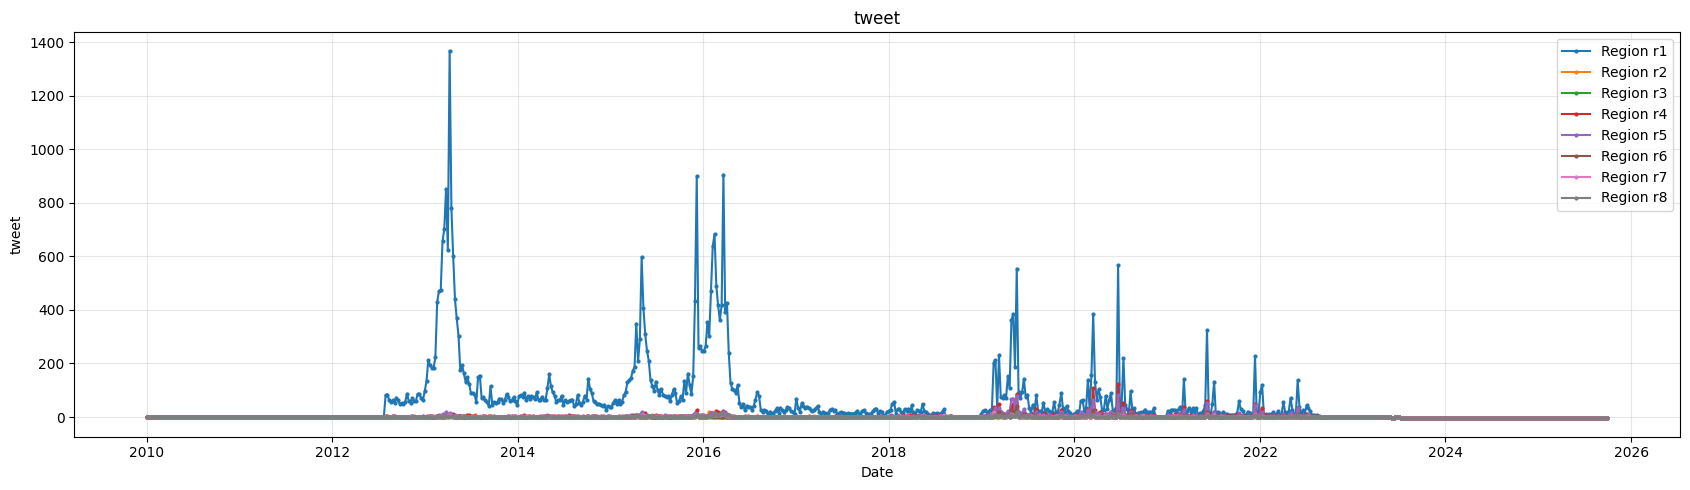

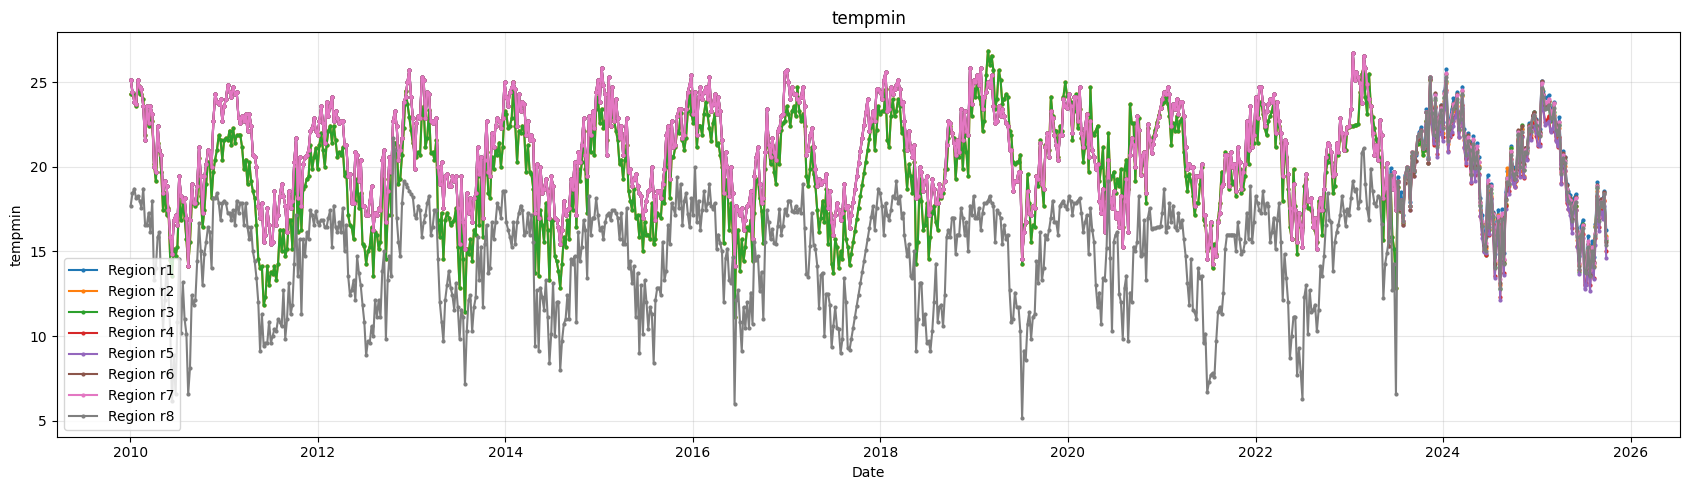

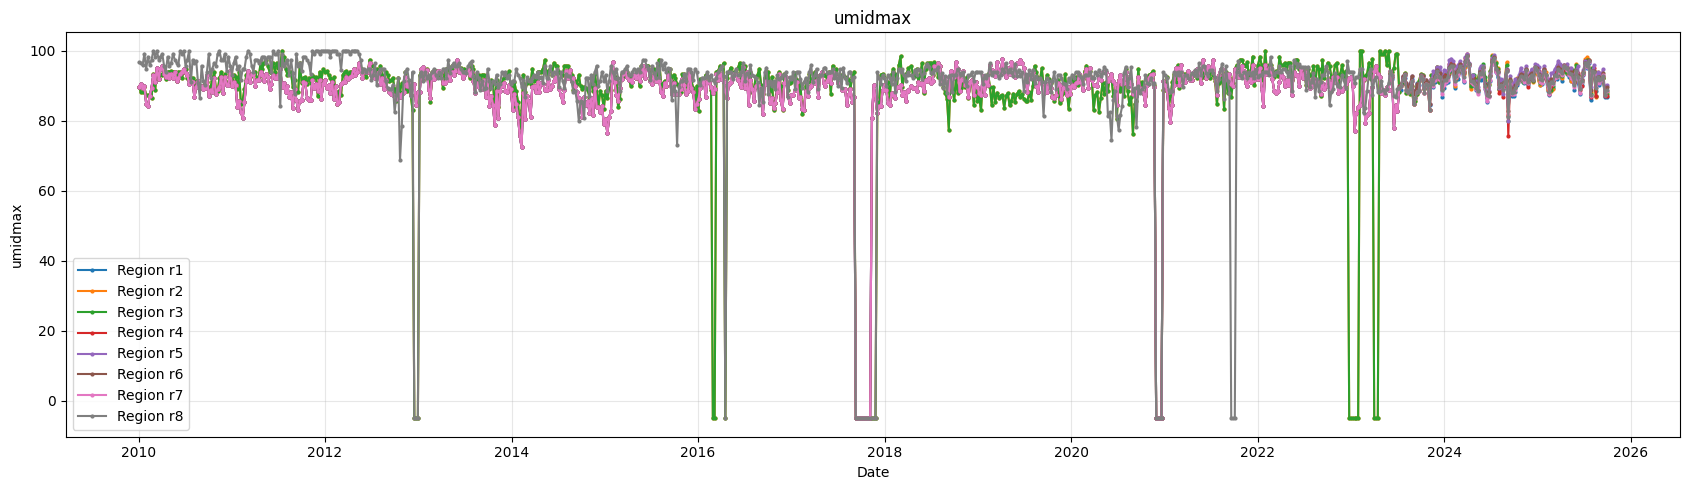

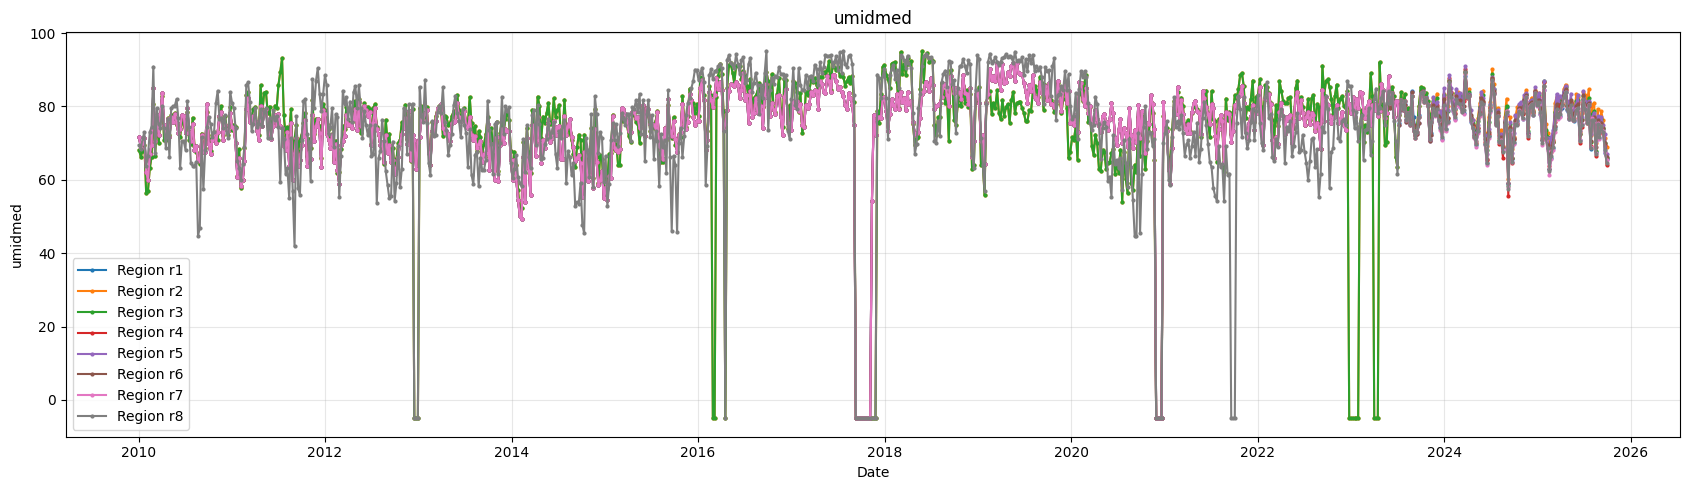

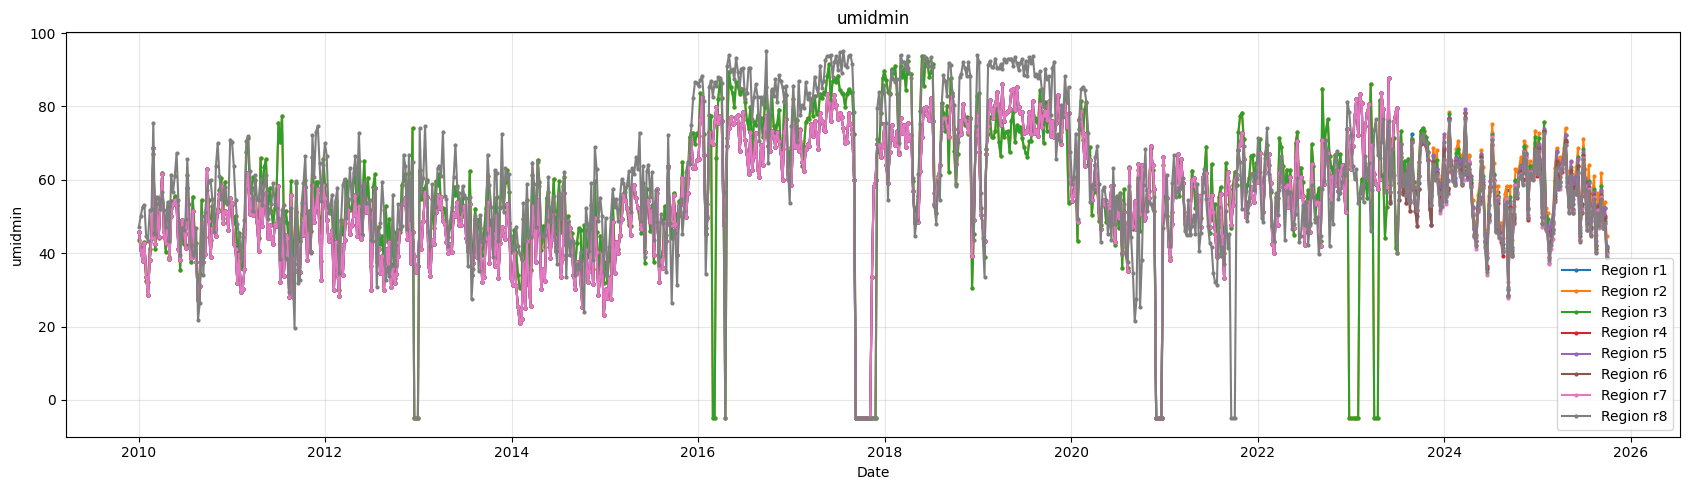

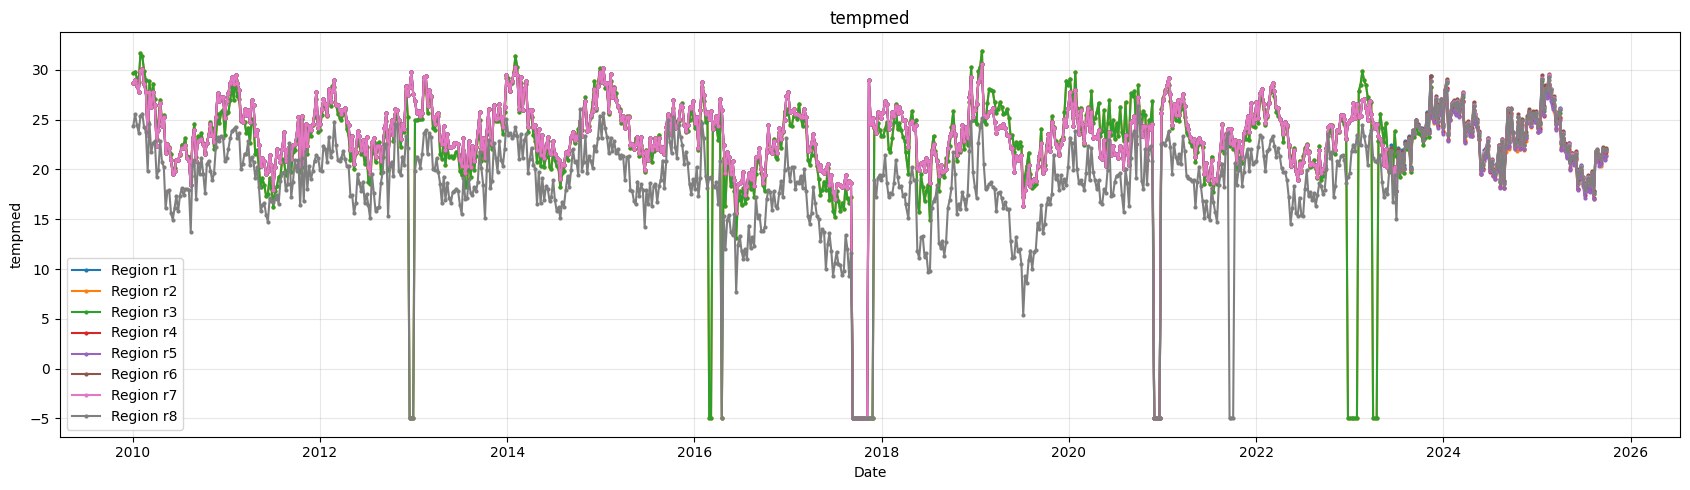

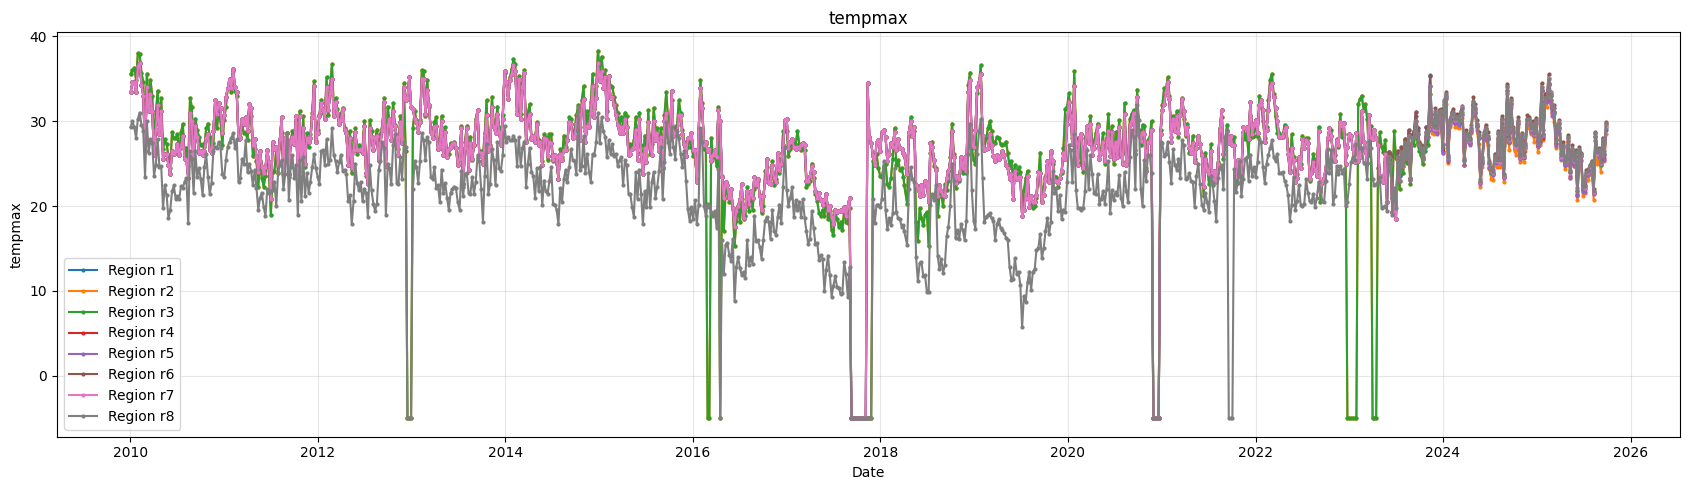

In [13]:
vars_to_plot = ['p_inc100k','tweet','tempmin','umidmax','umidmed','umidmin','tempmed','tempmax']
plot_ts(all_filt, vars_to_plot, date_col="data_iniSE", region_col="region", na_fill=-5)

In [14]:
## From the graph above, tweet data seems to exists for only the rio, therefore I will not include tweets
all_filt2 = all_filt.copy()
all_filt2.drop(columns=['tweet'], inplace=True)
all_filt2.head(5)

,data_iniSE,nivel,p_inc100k,Rt,p_rt1,tempmin,umidmax,umidmed,umidmin,tempmed,tempmax,region
0,2025-09-28,1,4.663553,1.010159,0.549897,16.264375,86.827100,65.549950,41.754125,22.025125,28.983125,r1
1,2025-09-21,1,4.542814,1.022164,0.605514,18.566014,86.685729,67.339200,48.662471,21.936329,26.060614,r1
2,2025-09-14,1,4.889939,1.152180,0.959198,18.123229,92.134557,73.900929,49.199000,22.083943,27.310429,r1
3,2025-09-07,1,4.422075,1.046171,0.705604,18.081414,90.972957,74.983886,56.739414,21.020400,24.826800,r1
4,2025-08-31,1,4.195689,0.962061,0.322483,17.369214,90.180243,71.318800,48.862986,21.417529,26.341886,r1


## Data Preparation For XGBOOST

Transform the data to make the brazilian dataset as  to be more general (based on only incidence and weathers info) by:
- Making the pseudo Rt from the incidence cases (to be added)
- Change the nivel (alarm level) into 0/1 where 0 is flat or going down and 1 is if there is an increase in level
- Shift this nivel depending on horizon that i want to train (i.e. temp today as X-label and nivel tmrrw as y-label)
- Make more features from lag values (i.e. feature 1 : temp today, feature 2 : temp yesterday, and so on)

In [15]:
def add_lags(df, cols, max_lag=4, include_lag0=False):

    df = df.sort_values(['region','data_iniSE']).copy()
    g = df.groupby('region', group_keys=False)
    for c in cols:
        if include_lag0:
            df[f"{c}_lag0"] = g[c].shift(0)
        for L in range(1, max_lag + 1):
            df[f"{c}_lag{L}"] = g[c].shift(L)
    return df

In [16]:
def prep(df, h=1, train_frac=0.75, lag_cols=None, max_lag=4, include_lag0=False):

    df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])
    df = df.sort_values(['region','data_iniSE'])

    # change nivel to binary and shift depending on the horizon
    df['nivel_binary'] = df.groupby('region')['nivel'].diff().gt(0).astype(int).fillna(0)
    df['nivel_binary'] = df.groupby('region')['nivel_binary'].shift(-h)


    for c in ['Rt','p_rt1','nivel']:
        if c in df.columns:
            df = df.drop(columns=c)

    if lag_cols is None:
        non_feat = {'data_iniSE','region','nivel_binary'}
        lag_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in non_feat]

    df = add_lags(df, lag_cols, max_lag=max_lag, include_lag0=include_lag0)

    added_lag_cols = []
    if include_lag0:
        added_lag_cols += [f"{c}_lag0" for c in lag_cols]
    added_lag_cols += [f"{c}_lag{L}" for c in lag_cols for L in range(1, max_lag+1)]

    regs = df['region'].unique()
    tr_parts, te_parts = [], []
    need_cols = ['nivel_binary'] + added_lag_cols

    for r in regs:
        gdf = df[df['region'] == r].copy()
        n = len(gdf)
        tr_end = int(np.floor(train_frac * n))
        print(f"region: {r}, total week: {n}, train until week: {tr_end}")

        g_tr = gdf.iloc[:tr_end].dropna(subset=need_cols)
        g_te = gdf.iloc[tr_end:].dropna(subset=need_cols)

        tr_parts.append(g_tr)
        te_parts.append(g_te)

    data_ml  = pd.concat(tr_parts, ignore_index=True).dropna()
    data_test = pd.concat(te_parts, ignore_index=True).dropna()
    return data_ml, data_test

In [17]:
data_ml, data_test = prep(all_filt2)
data_ml.head(5)

region: r1, total week: 822, train until week: 616
region: r2, total week: 822, train until week: 616
region: r3, total week: 822, train until week: 616
region: r4, total week: 822, train until week: 616
region: r5, total week: 822, train until week: 616
region: r6, total week: 822, train until week: 616
region: r7, total week: 822, train until week: 616
region: r8, total week: 822, train until week: 616


,data_iniSE,p_inc100k,tempmin,umidmax,umidmed,umidmin,tempmed,tempmax,region,nivel_binary,...,umidmin_lag3,umidmin_lag4,tempmed_lag1,tempmed_lag2,tempmed_lag3,tempmed_lag4,tempmax_lag1,tempmax_lag2,tempmax_lag3,tempmax_lag4
0,2010-01-31,1.007734,25.142857,84.857143,62.218228,33.571429,29.935030,36.428571,r1,0.0,...,40.857143,45.857143,27.822510,28.344092,29.021947,28.714322,33.428571,34.571429,34.571429,33.428571
1,2010-02-07,0.829898,24.714286,84.285714,60.058147,28.714286,30.084216,36.857143,r1,0.0,...,37.857143,40.857143,29.935030,27.822510,28.344092,29.021947,36.428571,33.428571,34.571429,34.571429
2,2010-02-14,0.978094,24.571429,87.142857,66.984586,38.285714,28.563047,34.285714,r1,0.0,...,42.857143,37.857143,30.084216,29.935030,27.822510,28.344092,36.857143,36.428571,33.428571,34.571429
3,2010-02-21,1.096651,23.571429,89.428571,69.616341,44.142857,27.736358,33.000000,r1,0.0,...,33.571429,42.857143,28.563047,30.084216,29.935030,27.822510,34.285714,36.857143,36.428571,33.428571
4,2010-02-28,1.407863,21.571429,93.142857,85.098077,68.714286,23.448435,26.428571,r1,0.0,...,28.714286,33.571429,27.736358,28.563047,30.084216,29.935030,33.000000,34.285714,36.857143,36.428571


Xy split

In [18]:
NON_FEAT = {"data_iniSE", "region", "nivel_binary"}

def make_Xy(df):
    cols = [c for c in df.columns if c not in NON_FEAT]
    # cols = ['p_inc100k', 'tempmin', 'tempmin_lag1', 'p_inc100k_lag1']
    X = df[cols]
    y = df["nivel_binary"].astype(int)
    return X, y, cols

In [19]:
X_train_raw, y_train, feat_cols = make_Xy(data_ml)
X_test_raw = data_test.reindex(columns=feat_cols)
y_test = data_test["nivel_binary"].astype(int)

## Class Imbalance - SMOT-EEN Sampling (Illustration Purposes)

In [20]:
def plot_pie (y, title=""):
    vc = pd.Series(y).value_counts().sort_index()
    labels = [f"{cls} ({cnt}, {cnt/len(y):.1%})" for cls, cnt in vc.items()]
    plt.figure(figsize=(5,5))
    plt.pie(vc.values, labels=labels,  colors=["darkblue", "darkred"], startangle=90)
    plt.title(title)
    plt.axis("equal")
    plt.show()

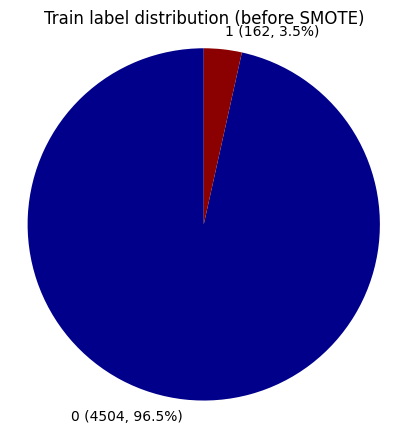

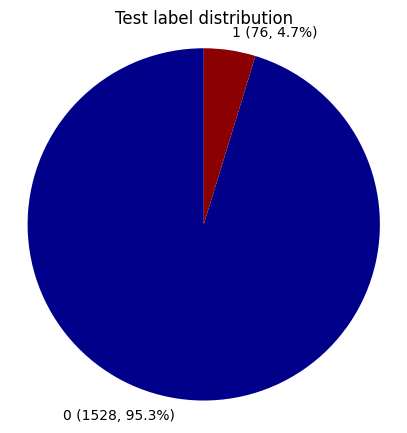

In [21]:
plot_pie(y_train, "Train label distribution (before SMOTE)")
plot_pie(y_test,  "Test label distribution")

SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

EEN (Edited Nearest Neighbors) is a "cleaning" mechanism.

By combining SMOTE with ENN, SMOTENN is able to generate synthetic samples that are more representative of the minority class and reduce the presence of noisy samples. This can lead to improved generalization performance of the model.

In [22]:
# SMOTE-EEN Sampling
smenn = SMOTEENN()
X_train2, y_train2 = smenn.fit_resample (X_train_raw, y_train)

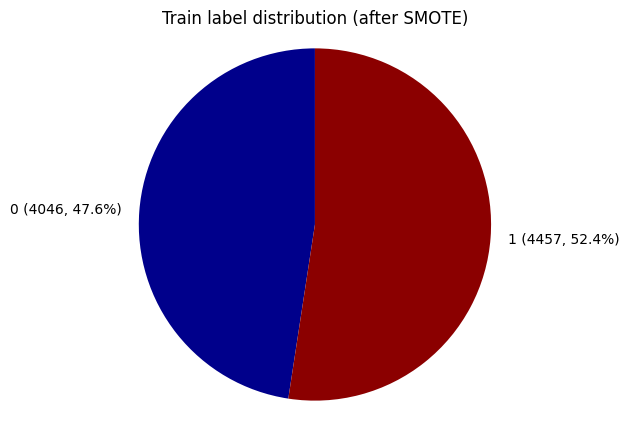

In [23]:
plot_pie(y_train2, "Train label distribution (after SMOTE)")

## XGB Models

In [24]:
select_param_xgb = XGBClassifier(
    objective="binary:logistic", eval_metric="aucpr",
    n_estimators=300, max_depth=3, learning_rate=0.06,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)

In [25]:
fin_xgb = XGBClassifier(
    objective="binary:logistic", eval_metric="aucpr",
    tree_method="hist", random_state=42
)

## Make Pipeline For Gridsearch

In [26]:
pipe = Pipeline([
    ("scale",    StandardScaler()),
    ("smoteenn", SMOTEENN(smote=SMOTE(random_state=42), random_state=42)),
    ("select",   SelectFromModel(select_param_xgb, threshold="median")),
    ("xgb",      fin_xgb),
])

## Gridsearch

In [27]:
param_grid = {
    # "smoteenn__sampling_strategy": [0.5, 0.7, 1.0],
    # "smoteenn__smote__k_neighbors": [3, 5],
    "select__threshold": ["median", "mean"],
    "xgb__n_estimators": [400, 800],
    "xgb__max_depth": [3, 4, 5],
    "xgb__learning_rate": [0.03, 0.06],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0],
}

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    #scoring via balanced acc due to imbalanced data
    scoring=make_scorer(balanced_accuracy_score),
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
)

In [29]:
# gs.fit(X_train_raw, y_train)

# print("Best CV balanced accuracy:", gs.best_score_)
# print("Best params:", gs.best_params_)

In [30]:
# best_model = gs.best_estimator_

In [31]:
# selector    = best_model.named_steps["select"]

# mask = selector.get_support()

# if hasattr(X_train_raw, "columns"):
#     all_cols = np.asarray(X_train_raw.columns)
# else:
#     all_cols = np.asarray(feature_cols)

# selected_cols = all_cols[mask]
# dropped_cols  = all_cols[~mask]

# print(f"{mask.sum()} features kept / {len(all_cols)} total")
# print("Selected features:", selected_cols.tolist())

In [33]:

horizon = 4
best_mod_list = []

do_gs = False

drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive"
models_dir = os.path.join(base_dir, "best_models_xgb")
os.makedirs(models_dir, exist_ok=True)

if do_gs:

    for hh in range(horizon):
        print("Process horizon", hh+1)

        # Make datasets
        data_ml, data_test = prep(all_filt2, h=hh+1)

        # Split X / y
        X_train_raw, y_train, feat_cols = make_Xy(data_ml)
        X_test_raw = data_test.reindex(columns=feat_cols)
        y_test = data_test["nivel_binary"].astype(int)

        # Grid search per horizon
        gs.fit(X_train_raw, y_train)
        print(f"[h{hh+1}] best CV balanced acc: {gs.best_score_:.4f}")
        print(f"[h{hh+1}] best params:", gs.best_params_)

        # Best pipeline
        best_model = gs.best_estimator_
        best_mod_list.append(best_model)

        # Feature mask (optional reporting)
        selector = best_model.named_steps["select"]
        mask = selector.get_support()
        all_cols = np.asarray(feat_cols)
        selected_cols = all_cols[mask]
        print(f"[h{hh+1}] kept {mask.sum()}/{len(all_cols)} features")

        # SAVE actual model object
        joblib.dump(best_model, os.path.join(models_dir, f"best_model_h{hh+1}.joblib"))

    # Optional: also save a short text summary
    summary_path = os.path.join(models_dir, "best_models_summary.txt")
    with open(summary_path, "w", encoding="utf-8") as f:
        for i, model in enumerate(best_mod_list, 1):
            f.write(f"--- Horizon {i} ---\n{model}\n\n")
    print(f"Saved {len(best_mod_list)} models to: {models_dir}")

else:
    # READ (rebuild best_mod_list from saved .joblib files)
    paths = glob.glob(os.path.join(models_dir, "best_model_h*.joblib"))
    if not paths:
        raise FileNotFoundError(f"No saved models found in {models_dir}")
    # sort by horizon number
    paths = sorted(paths, key=lambda p: int(re.search(r'h(\d+)', p).group(1)))
    best_mod_list = [joblib.load(p) for p in paths]
    print(f"Loaded {len(best_mod_list)} models:", [os.path.basename(p) for p in paths])

    # Example use:
    # y_pred = best_mod_list[0].predict(X_test_raw_for_h1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 4 models: ['best_model_h1.joblib', 'best_model_h2.joblib', 'best_model_h3.joblib', 'best_model_h4.joblib']


## Test

Process horizon 1
region: r1, total week: 822, train until week: 616
region: r2, total week: 822, train until week: 616
region: r3, total week: 822, train until week: 616
region: r4, total week: 822, train until week: 616
region: r5, total week: 822, train until week: 616
region: r6, total week: 822, train until week: 616
region: r7, total week: 822, train until week: 616
region: r8, total week: 822, train until week: 616
XGBoost Balanced Accuracy: 0.81
F1 Score: 0.29
Recall: 0.8
Precision: 0.18


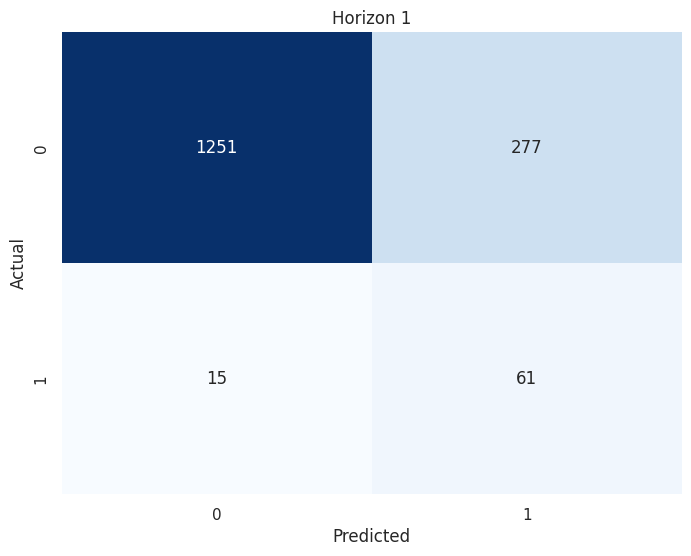

Process horizon 2
region: r1, total week: 822, train until week: 616
region: r2, total week: 822, train until week: 616
region: r3, total week: 822, train until week: 616
region: r4, total week: 822, train until week: 616
region: r5, total week: 822, train until week: 616
region: r6, total week: 822, train until week: 616
region: r7, total week: 822, train until week: 616
region: r8, total week: 822, train until week: 616
XGBoost Balanced Accuracy: 0.71
F1 Score: 0.2
Recall: 0.66
Precision: 0.12


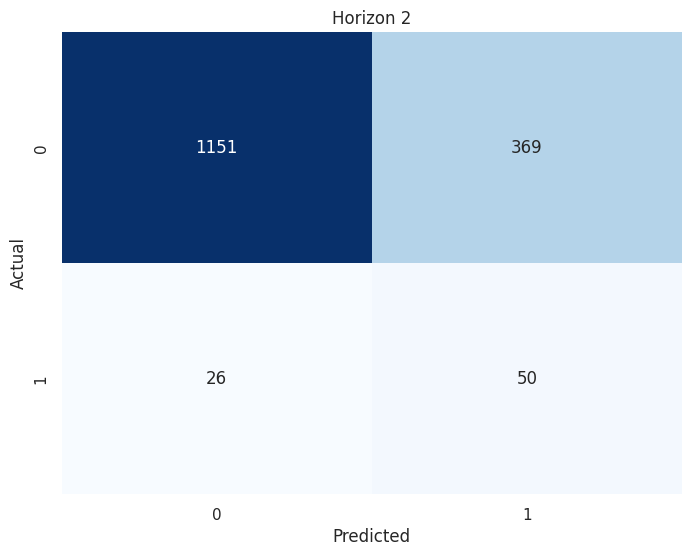

Process horizon 3
region: r1, total week: 822, train until week: 616
region: r2, total week: 822, train until week: 616
region: r3, total week: 822, train until week: 616
region: r4, total week: 822, train until week: 616
region: r5, total week: 822, train until week: 616
region: r6, total week: 822, train until week: 616
region: r7, total week: 822, train until week: 616
region: r8, total week: 822, train until week: 616
XGBoost Balanced Accuracy: 0.59
F1 Score: 0.15
Recall: 0.34
Precision: 0.1


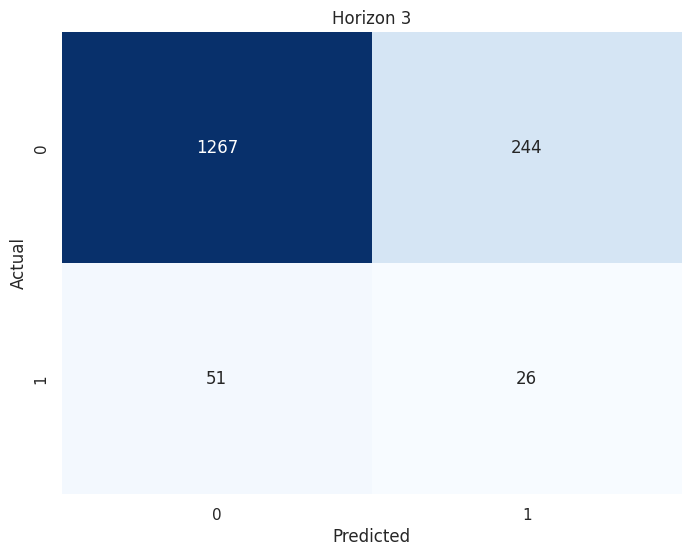

Process horizon 4
region: r1, total week: 822, train until week: 616
region: r2, total week: 822, train until week: 616
region: r3, total week: 822, train until week: 616
region: r4, total week: 822, train until week: 616
region: r5, total week: 822, train until week: 616
region: r6, total week: 822, train until week: 616
region: r7, total week: 822, train until week: 616
region: r8, total week: 822, train until week: 616
XGBoost Balanced Accuracy: 0.61
F1 Score: 0.16
Recall: 0.4
Precision: 0.1


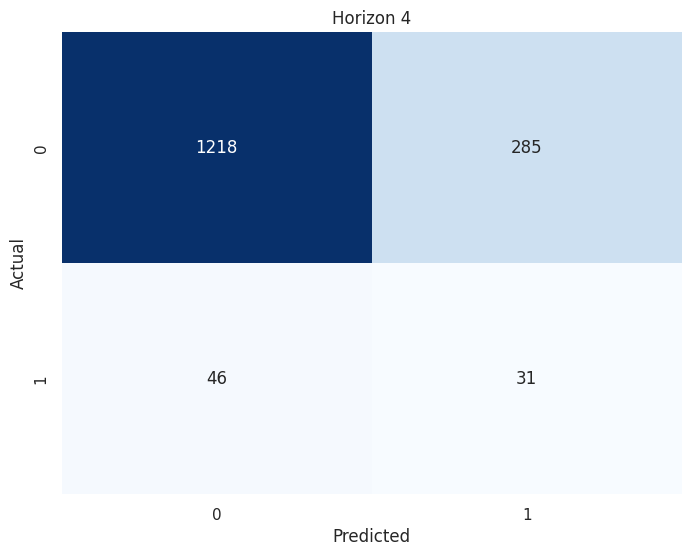

In [35]:
y_pred_df = pd.DataFrame()

i = 0
for best_model in best_mod_list:

  print("Process horizon", i+1)

  ## Make dataset
  data_ml, data_test = prep(all_filt2, h=i+1) #fix later to streamline better
  i +=1

  ## Split Xy
  X_train_raw, y_train, feat_cols = make_Xy(data_ml)
  X_test_raw = data_test.reindex(columns=feat_cols)
  y_test = data_test["nivel_binary"].astype(int)

  y_pred = best_model.predict(X_test_raw)

  # Calculate evaluation metrics
  accuracy = balanced_accuracy_score(y_test, y_pred) #accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  print("XGBoost Balanced Accuracy:", round(accuracy,2))
  print("F1 Score:", round(f1,2))
  print("Recall:", round(recall,2))
  print("Precision:", round(precision,2))

  # PLot Heeatmap
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.set_theme(style="whitegrid")
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.title(f"Horizon {i}")
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()